# Data Preprocessing

In [ ]:
# first create API key from kaggle account to retrieve a kaggle.json file
from google.colab import drive
drive.mount('/content/drive')

!pip -q install kaggle

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from pathlib import Path
import shutil
import json, numpy as np, pandas as pd
from sklearn.model_selection import train_test_split
from PIL import Image, UnidentifiedImageError
import pandas as pd

In [ ]:
# kaggle.json location
KAGGLE_JSON = "/content/drive/MyDrive/Bharde_429_Final/kaggle.json"

!mkdir -p ~/.kaggle
!cp -f "$KAGGLE_JSON" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# sanity check
!kaggle --version

Kaggle API 1.7.4.5


In [ ]:
# save paths and create folders
PROJECT_ROOT = "/content/drive/MyDrive/Bharde_429_Final"
ZIP_PATH = f"{PROJECT_ROOT}/asl-alphabet.zip"
LOCAL_UNZIP = "/content/asl_alphabet_unzipped"

!mkdir -p "{PROJECT_ROOT}"
!mkdir -p "{LOCAL_UNZIP}"

!ls -lh "{PROJECT_ROOT}" | tail

total 1.1G
drwx------ 2 root root 4.0K Nov 12 17:52 artifacts
drwx------ 2 root root 4.0K Nov 12 17:45 asl_alphabet_unzipped
-rw------- 1 root root 1.1G Sep 29  2019 asl-alphabet.zip
drwx------ 2 root root 4.0K Nov 12 17:59 checkpoints
-rw------- 1 root root   62 Nov 12 00:58 kaggle.json
drwx------ 2 root root 4.0K Nov 12 19:30 new_asl_alphabet_test
-rw------- 1 root root   18 Nov 10 18:25 README.md
drwx------ 2 root root 4.0K Nov 12 17:59 results
-rw------- 1 root root 134K Nov 12 19:37 ta_model.ipynb


In [ ]:
# download (quietly, overwrites existing zip)
!kaggle datasets download -d grassknoted/asl-alphabet -p "{PROJECT_ROOT}" -q

print("Download complete. Contents of project folder:")
!ls -lh "{PROJECT_ROOT}" | grep "asl-alphabet.zip" || echo "Zip not found."

Dataset URL: https://www.kaggle.com/datasets/grassknoted/asl-alphabet
License(s): GPL-2.0
Download complete. Contents of project folder:
-rw------- 1 root root 1.1G Sep 29  2019 asl-alphabet.zip


In [ ]:
# unzip data
DEST = LOCAL_UNZIP
!unzip -q -o "{ZIP_PATH}" -d "{DEST}"

print("Unzip complete. Local contents:")
!ls -l "{DEST}" | head -n 80

Unzip complete. Local contents:
total 8
drwxr-xr-x 3 root root 4096 Nov 12 19:38 asl_alphabet_test
drwxr-xr-x 3 root root 4096 Nov 12 19:38 asl_alphabet_train


In [ ]:
# current parent
BASE = Path("/content/asl_alphabet_unzipped/asl_alphabet_train")
# the nested one
INNER = BASE / "asl_alphabet_train"

if INNER.exists() and INNER.is_dir():
    for item in INNER.iterdir():
        shutil.move(str(item), str(BASE))
    shutil.rmtree(INNER)
    print("Flattened: moved contents up to", BASE)
else:
    print("No nested folder to flatten at:", INNER)

Flattened: moved contents up to /content/asl_alphabet_unzipped/asl_alphabet_train


In [ ]:
# current parent
BASE = Path("/content/asl_alphabet_unzipped/asl_alphabet_test")
# the nested one
INNER = BASE / "asl_alphabet_test"

if INNER.exists() and INNER.is_dir():
    for item in INNER.iterdir():
        shutil.move(str(item), str(BASE))
    shutil.rmtree(INNER)
    print("Flattened: moved contents up to", BASE)
else:
    print("No nested folder to flatten at:", INNER)

Flattened: moved contents up to /content/asl_alphabet_unzipped/asl_alphabet_test


In [ ]:
# now flat
DATA_ROOT = Path("/content/asl_alphabet_unzipped/asl_alphabet_train")
ACCEPT = {".jpg", ".jpeg", ".png"}

rows = []
for cdir in sorted([d for d in DATA_ROOT.iterdir() if d.is_dir()]):
    label = cdir.name
    count = sum(1 for p in cdir.rglob("*") if p.is_file() and p.suffix.lower() in ACCEPT)
    rows.append((label, count))

counts = pd.DataFrame(rows, columns=["class","count"]).sort_values("class")
print("Classes found:", len(counts))
print("Total images :", counts["count"].sum())
counts.head(10)

Classes found: 29
Total images : 87000


,class,count
0,A,3000
1,B,3000
2,C,3000
3,D,3000
4,E,3000
5,F,3000
6,G,3000
7,H,3000
8,I,3000
9,J,3000


In [ ]:
# path to your test folder
DATA_ROOT = Path("/content/asl_alphabet_unzipped/asl_alphabet_test")

# file extensions to include
ACCEPT = {".jpg", ".jpeg", ".png"}

# count images directly (no subfolders)
image_files = [p for p in DATA_ROOT.iterdir() if p.is_file() and p.suffix.lower() in ACCEPT]

print(f"Total images found in test folder: {len(image_files)}")

Total images found in test folder: 28


In [ ]:
# project paths
PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
DATA_ROOT    = Path("/content/asl_alphabet_unzipped/asl_alphabet_train")
ARTIFACTS    = PROJECT_ROOT / "artifacts"
ARTIFACTS.mkdir(parents=True, exist_ok=True)

SEED = 429
ACCEPT = {".jpg", ".jpeg", ".png"}

In [ ]:
# scan class folders recursively
rows = []
for cdir in sorted([d for d in DATA_ROOT.iterdir() if d.is_dir()]):
    label = cdir.name
    for p in cdir.rglob("*"):
        if p.is_file() and p.suffix.lower() in ACCEPT:
            rows.append((str(p), label))

df = pd.DataFrame(rows, columns=["path", "label"])
print("Total images (raw):", len(df))
print("Classes found:", df["label"].nunique(), sorted(df["label"].unique())[:10], "...")

# keep A–Z + 'space'; drop 'del' & 'nothing'
keep = [chr(c) for c in range(ord('A'), ord('Z')+1)] + ["space"]
drop = {"del", "nothing"}
before = len(df)
df = df[~df["label"].isin(drop)]
df = df[df["label"].isin(keep)].reset_index(drop=True)
print(f"After filter: {len(df)} images (dropped {before - len(df)}) across {df['label'].nunique()} classes")

# corrupt-image check (verifies files open)
good_idx = []
for i, p in enumerate(df["path"]):
    try:
        with Image.open(p) as im:
            im.verify()
        good_idx.append(i)
    except (UnidentifiedImageError, OSError):
        pass

if len(good_idx) != len(df):
    print("Removed corrupt images:", len(df) - len(good_idx))
df = df.iloc[good_idx].reset_index(drop=True)
print("Images after corrupt check:", len(df))

Total images (raw): 87000
Classes found: 29 ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J'] ...
After filter: 81000 images (dropped 6000) across 27 classes
Images after corrupt check: 81000


In [ ]:
# encode labels and save class map
classes = sorted(keep)
class_to_idx = {c: i for i, c in enumerate(classes)}
df["y"] = df["label"].map(class_to_idx)

with open(ARTIFACTS / "class_to_idx.json", "w") as f:
    json.dump(class_to_idx, f, indent=2)

# stratified split (seed = 429) and save indices + manifests
idx = np.arange(len(df))
y = df["y"].to_numpy()

train_idx, val_idx = train_test_split(
    idx, test_size=0.2, stratify=y, random_state=SEED
)

np.save(ARTIFACTS / "train_idx.npy", train_idx)
np.save(ARTIFACTS / "val_idx.npy", val_idx)

df_train = df.iloc[train_idx].reset_index(drop=True)
df_val   = df.iloc[val_idx].reset_index(drop=True)

df.to_csv(ARTIFACTS / "manifest_filtered.csv", index=False)
df_train.to_csv(ARTIFACTS / "train_manifest.csv", index=False)
df_val.to_csv(ARTIFACTS / "val_manifest.csv", index=False)

print("Train size:", len(train_idx), "| Val size:", len(val_idx))
print("Artifacts saved to:", ARTIFACTS.resolve())

Train size: 64800 | Val size: 16200
Artifacts saved to: /content/drive/MyDrive/Bharde_429_Final/artifacts


In [ ]:
print("Per-class sample counts (train):")
print(df_train["label"].value_counts().sort_index().head(10))
print("\nPer-class sample counts (val):")
print(df_val["label"].value_counts().sort_index().head(10))

Per-class sample counts (train):
label
A    2400
B    2400
C    2400
D    2400
E    2400
F    2400
G    2400
H    2400
I    2400
J    2400
Name: count, dtype: int64

Per-class sample counts (val):
label
A    600
B    600
C    600
D    600
E    600
F    600
G    600
H    600
I    600
J    600
Name: count, dtype: int64


# Model Training

In [ ]:
# T-A: Head-only fine-tuning (ResNet-18)
from pathlib import Path
import json, random, numpy as np, pandas as pd, contextlib
from PIL import Image
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.metrics import f1_score, confusion_matrix
import matplotlib.pyplot as plt


PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
ART          = PROJECT_ROOT / "artifacts"
CKPT         = PROJECT_ROOT / "checkpoints"; CKPT.mkdir(exist_ok=True)
RESULTS      = PROJECT_ROOT / "results";     RESULTS.mkdir(exist_ok=True)

SEED = 429
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device("cuda" if USE_CUDA else "cpu")
amp_ctx = torch.autocast(device_type="cuda", dtype=torch.float16) if USE_CUDA else contextlib.nullcontext()
if USE_CUDA: torch.backends.cudnn.benchmark = True
print("Device:", DEVICE)

Device: cuda


In [ ]:
# load artifacts
with open(ART / "class_to_idx.json") as f:
    class_to_idx = json.load(f)
classes = [c for c,_ in sorted(class_to_idx.items(), key=lambda kv: kv[1])]
NUM_CLASSES = len(classes)

df_train = pd.read_csv(ART / "train_manifest.csv")
df_val   = pd.read_csv(ART / "val_manifest.csv")

# transforms (ImageNet)
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

class ImageCSV(Dataset):
    def __init__(self, df, transform=None):
        self.paths = df["path"].tolist()
        self.targets = (df["y"] if "y" in df.columns else df["label"].map(class_to_idx)).astype(int).tolist()
        self.transform = transform
    def __len__(self): return len(self.paths)
    def __getitem__(self, i):
        img = Image.open(self.paths[i]).convert("RGB")
        if self.transform: img = self.transform(img)
        return img, self.targets[i]

train_ds = ImageCSV(df_train, tfm)
val_ds   = ImageCSV(df_val,   tfm)

BATCH_SIZE, NUM_WORKERS = 64, 4
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=2)
val_loader   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False,
                          num_workers=NUM_WORKERS, persistent_workers=True, prefetch_factor=2)

print("Batches -> train:", len(train_loader), "| val:", len(val_loader), "| classes:", NUM_CLASSES)

Batches -> train: 1013 | val: 254 | classes: 27


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_feats = model.fc.in_features
model.fc = nn.Linear(in_feats, NUM_CLASSES)

# freeze all except head
for p in model.parameters(): p.requires_grad = False
for p in model.fc.parameters(): p.requires_grad = True

# keep BN layers in eval when frozen
def set_bn_eval(m):
    if isinstance(m, nn.BatchNorm2d): m.eval()
model.apply(set_bn_eval)

model = model.to(DEVICE).to(memory_format=torch.channels_last)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam([p for p in model.parameters() if p.requires_grad], lr=1e-3)

trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
total     = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable:,} / {total:,}")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 131MB/s]


Trainable params: 13,851 / 11,190,363


In [ ]:
def _batch_correct(logits, y):
    preds = logits.argmax(1)
    return preds, (preds == y).sum().item()

@torch.no_grad()
def evaluate(model, loader, return_preds=False):
    model.eval()
    total, correct, loss_sum = 0, 0, 0.0
    all_pred, all_true = [], []
    for xb, yb in loader:
        xb = xb.to(DEVICE, memory_format=torch.channels_last)
        yb = torch.as_tensor(yb, device=DEVICE)
        with amp_ctx:
            logits = model(xb)
            loss = criterion(logits, yb)
        loss_sum += loss.item() * xb.size(0)
        preds, corr = _batch_correct(logits, yb)
        all_pred.extend(preds.cpu().tolist()); all_true.extend(yb.cpu().tolist())
        correct += corr; total += xb.size(0)
    acc = correct / total
    f1  = f1_score(all_true, all_pred, average="macro")
    return (loss_sum/total, acc, f1, (all_pred, all_true)) if return_preds else (loss_sum/total, acc, f1)

In [ ]:
from copy import deepcopy

EPOCHS = 10
history = {"train_loss":[], "train_acc":[], "val_loss":[], "val_acc":[], "val_f1":[]}
best_f1, best_state, patience, bad = -1.0, None, 2, 0

for epoch in range(1, EPOCHS+1):
    model.train()
    tr_tot, tr_corr, tr_loss_sum = 0, 0, 0.0
    for xb, yb in train_loader:
        xb = xb.to(DEVICE, memory_format=torch.channels_last)
        yb = torch.as_tensor(yb, device=DEVICE)

        optimizer.zero_grad(set_to_none=True)
        with amp_ctx:
            logits = model(xb)
            loss = criterion(logits, yb)
        loss.backward(); optimizer.step()

        tr_loss_sum += loss.item() * xb.size(0)
        preds, corr = _batch_correct(logits, yb)
        tr_corr += corr; tr_tot += xb.size(0)

    tr_loss = tr_loss_sum / tr_tot
    tr_acc  = tr_corr / tr_tot

    va_loss, va_acc, va_f1 = evaluate(model, val_loader)

    history["train_loss"].append(tr_loss)
    history["train_acc"].append(tr_acc)
    history["val_loss"].append(va_loss)
    history["val_acc"].append(va_acc)
    history["val_f1"].append(va_f1)

    tag = ""
    if va_f1 > best_f1:
        best_f1, best_state, bad, tag = va_f1, deepcopy(model.state_dict()), 0, "<= BEST"
    else:
        bad += 1
    print(f"Epoch {epoch:02d} | train {tr_loss:.4f}/{tr_acc:.3f} | val {va_loss:.4f}/{va_acc:.3f} F1 {va_f1:.4f} {tag}")
    if bad > patience:
        print("Early stopping (macro-F1 plateau)."); break

best_path = CKPT / "best_TA.pt"
torch.save(best_state, best_path)
print("Saved best checkpoint:", best_path, "| Best val macro-F1:", f"{best_f1:.4f}")

Epoch 01 | train 0.8685/0.827 | val 0.3492/0.932 F1 0.9322 <= BEST
Epoch 02 | train 0.2908/0.939 | val 0.2100/0.958 F1 0.9578 <= BEST
Epoch 03 | train 0.1982/0.956 | val 0.1537/0.965 F1 0.9654 <= BEST
Epoch 04 | train 0.1534/0.965 | val 0.1202/0.974 F1 0.9739 <= BEST
Epoch 05 | train 0.1279/0.969 | val 0.1043/0.975 F1 0.9750 <= BEST
Epoch 06 | train 0.1118/0.973 | val 0.0968/0.975 F1 0.9750 <= BEST
Epoch 07 | train 0.0991/0.975 | val 0.0817/0.980 F1 0.9803 <= BEST
Epoch 08 | train 0.0881/0.978 | val 0.0735/0.981 F1 0.9807 <= BEST
Epoch 09 | train 0.0808/0.980 | val 0.0697/0.982 F1 0.9817 <= BEST
Epoch 10 | train 0.0753/0.981 | val 0.0644/0.983 F1 0.9833 <= BEST
Saved best checkpoint: /content/drive/MyDrive/Bharde_429_Final/checkpoints/best_TA.pt | Best val macro-F1: 0.9833


In [ ]:
# curves
pd.DataFrame(history).to_csv(RESULTS / "TA_history.csv", index=False)

# confusion matrix on validation
model.load_state_dict(torch.load(best_path, map_location=DEVICE))
_, _, _, (preds, labels) = evaluate(model, val_loader, return_preds=True)
cm = confusion_matrix(labels, preds, labels=list(range(NUM_CLASSES)))
np.save(RESULTS / "TA_val_confusion_matrix.npy", cm)

print("Saved:", RESULTS / "TA_history.csv", "and", RESULTS / "TA_val_confusion_matrix.npy")

Saved: /content/drive/MyDrive/Bharde_429_Final/results/TA_history.csv and /content/drive/MyDrive/Bharde_429_Final/results/TA_val_confusion_matrix.npy


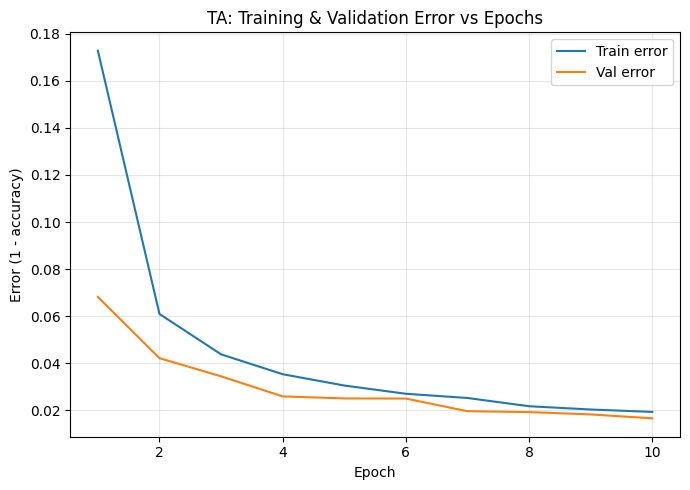

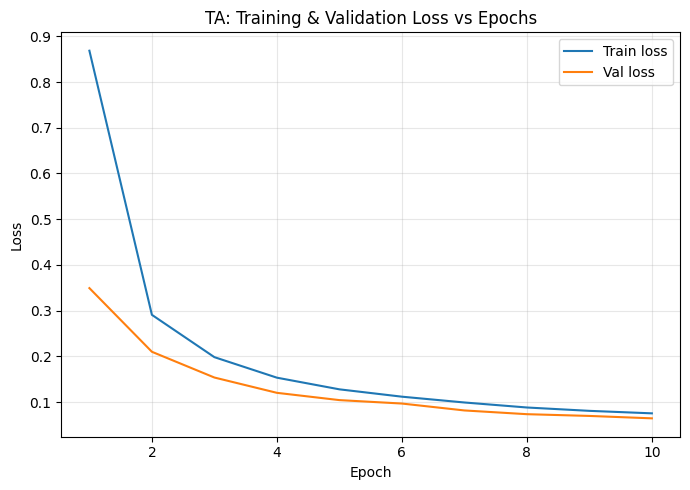

In [ ]:
RESULTS = PROJECT_ROOT / "results"

def plot_model_curves(TAG="TA"):
    hist_path = RESULTS / f"{TAG}_history.csv"
    df = pd.read_csv(hist_path)

    epochs = range(1, len(df)+1)

    # Training/Validation ERROR (1 - accuracy)
    tr_err = 1.0 - df["train_acc"]
    va_err = 1.0 - df["val_acc"]

    plt.figure(figsize=(7,5))
    plt.plot(epochs, tr_err, label="Train error")
    plt.plot(epochs, va_err, label="Val error")
    plt.xlabel("Epoch"); plt.ylabel("Error (1 - accuracy)")
    plt.title(f"{TAG}: Training & Validation Error vs Epochs")
    plt.grid(True, alpha=0.3); plt.legend()
    plt.tight_layout()
    plt.savefig(RESULTS / f"{TAG}_error_curves.png", dpi=200)
    plt.show()

    # Training/Validation LOSS
    if {"train_loss","val_loss"}.issubset(df.columns):
        plt.figure(figsize=(7,5))
        plt.plot(epochs, df["train_loss"], label="Train loss")
        plt.plot(epochs, df["val_loss"], label="Val loss")
        plt.xlabel("Epoch"); plt.ylabel("Loss")
        plt.title(f"{TAG}: Training & Validation Loss vs Epochs")
        plt.grid(True, alpha=0.3); plt.legend()
        plt.tight_layout()
        plt.savefig(RESULTS / f"{TAG}_loss_curves.png", dpi=200)
        plt.show()

plot_model_curves("TA")

# Model Testing

In [ ]:
from pathlib import Path
import json, numpy as np, pandas as pd
from PIL import Image
import torch
from torch import nn
from torchvision import models, transforms
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# paths
PROJECT_ROOT = Path("/content/drive/MyDrive/Bharde_429_Final")
ART          = PROJECT_ROOT / "artifacts"
CKPT_PATH    = PROJECT_ROOT / "checkpoints" / "best_TA.pt"
RESULTS      = PROJECT_ROOT / "results"
RESULTS.mkdir(exist_ok=True)

# where the unzipped Kaggle test lives
KAGGLE_TEST_DIR = Path("/content/asl_alphabet_unzipped/asl_alphabet_test")

# load class mapping (must match training)
with open(ART / "class_to_idx.json") as f:
    class_to_idx = json.load(f)
idx_to_class = {v:k for k,v in class_to_idx.items()}
classes = [idx_to_class[i] for i in range(len(idx_to_class))]

# device + transforms
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMG_SIZE = 224
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]
tfm = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGENET_MEAN, IMAGENET_STD),
])

# restore model (head-only ResNet-18 with correct num classes)
model = models.resnet18(weights=None)
model.fc = nn.Linear(model.fc.in_features, len(classes))
model.load_state_dict(torch.load(CKPT_PATH, map_location=DEVICE))
model = model.to(DEVICE).eval()
print("Loaded checkpoint:", CKPT_PATH.name, "| classes:", len(classes))

Loaded checkpoint: best_TA.pt | classes: 27


In [ ]:
from typing import List, Tuple
import os

def list_images_flat(root: Path) -> List[Path]:
    exts = {".jpg",".jpeg",".png"}
    return [p for p in sorted(root.iterdir()) if p.is_file() and p.suffix.lower() in exts]

def list_images_by_subfolders(root: Path) -> List[Tuple[Path,str]]:
    exts = {".jpg",".jpeg",".png"}
    items = []
    for d in sorted([x for x in root.iterdir() if x.is_dir()]):
        label = d.name
        for p in d.rglob("*"):
            if p.is_file() and p.suffix.lower() in exts:
                items.append((p, label))
    return items

@torch.no_grad()
def predict_paths(paths: List[Path]) -> List[int]:
    preds = []
    for p in paths:
        img = Image.open(p).convert("RGB")
        x = tfm(img).unsqueeze(0).to(DEVICE)
        logits = model(x)
        preds.append(int(logits.argmax(1).item()))
    return preds

def evaluate_folder(folder: Path, mode: str = "auto", save_tag: str = "TA"):
    """
    mode:
      - 'subfolders' : expects {root}/{CLASS}/*.jpg
      - 'flat'       : expects filenames that start with class letter (e.g., 'A_...jpg' or 'A_test.jpg')
      - 'auto'       : uses subfolders if any dirs exist, else flat
    """
    folder = Path(folder)
    assert folder.exists(), f"Folder not found: {folder}"

    # Decide mode
    if mode == "auto":
        mode = "subfolders" if any(x.is_dir() for x in folder.iterdir()) else "flat"

    paths, true_labels = [], []

    if mode == "subfolders":
        items = list_images_by_subfolders(folder)
        if len(items) == 0:
            raise RuntimeError("No images found under subfolders.")
        for p, lbl in items:
            if lbl not in class_to_idx:  # skip classes not in 27-class set
                continue
            paths.append(p)
            true_labels.append(class_to_idx[lbl])

    else:  # flat
        files = list_images_flat(folder)
        if len(files) == 0:
            raise RuntimeError("No images found in flat folder.")
        for p in files:
            # derive label from filename prefix before '_' or first char
            base = p.name
            letter = base.split("_")[0][0].upper()  # robust: 'A_test.jpg' or 'A_01.jpg'
            lbl = "space" if letter == " " else letter
            if lbl not in class_to_idx:
                # also support explicit names like 'space_test.jpg'
                prefix = base.split("_")[0].lower()
                if prefix in class_to_idx:
                    lbl = prefix
                else:
                    continue
            paths.append(p)
            true_labels.append(class_to_idx[lbl])

    # predict
    pred_idx = predict_paths(paths)
    acc = accuracy_score(true_labels, pred_idx)
    f1  = f1_score(true_labels, pred_idx, average="macro")
    cm  = confusion_matrix(true_labels, pred_idx, labels=list(range(len(classes))))

    # save artifacts
    out_csv = RESULTS / f"{save_tag}_predictions.csv"
    pd.DataFrame({
        "path": [str(p) for p in paths],
        "y_true": true_labels,
        "y_pred": pred_idx,
        "true_label": [idx_to_class[i] for i in true_labels],
        "pred_label": [idx_to_class[i] for i in pred_idx],
    }).to_csv(out_csv, index=False)

    out_npy = RESULTS / f"{save_tag}_cm.npy"
    np.save(out_npy, cm)

    print(f"[{save_tag}] files: {len(paths)} | acc: {acc:.4f} | macro-F1: {f1:.4f}")
    print("Saved:", out_csv.name, "and", out_npy.name)
    return acc, f1, cm

In [ ]:
acc_kaggle, f1_kaggle, cm_kaggle = evaluate_folder(
    KAGGLE_TEST_DIR, mode="flat", save_tag="TA_kaggle28"
)

[TA_kaggle28] files: 28 | acc: 0.9286 | macro-F1: 0.9259
Saved: TA_kaggle28_predictions.csv and TA_kaggle28_cm.npy


In [ ]:
# my created test set
MY_TEST_DIR = Path("/content/my_test")  # <-- change to your folder
acc_custom, f1_custom, cm_custom = evaluate_folder(
    MY_TEST_DIR, mode="auto", save_tag="TA_custom"
)